참고 링크 : https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

캐글의 자전거 대여 수요(Bike Shareing Demand) 예측 경연에서 사용된 데이터를 사용하여 선형 회귀 문제를 풀어봅시다.

### Description
* datetime - hourly date + timestamp  
* season -  1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
* holiday - 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
* workingday - 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather 
    - 1: 맑음, 약간 구름 낀 흐림  
    - 2: 안개, 안개 + 흐림  
    - 3: 가벼운 눈, 가벼운 비 + 천둥  
    - 4: 심한 눈/비, 천둥/번개 
* temp - 온도(섭씨)  
* atemp - 체감온도(섭씨)  
* humidity - 상대 습도  
* windspeed - 풍속  
* casual - 사전에 등록되지 않은 사용자가 대여한 횟수  
* registered - 사전에 등록된 사용자가 대여한 횟수  
* count - 대여 횟수  

### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('https://raw.githubusercontent.com/jesford/bike-sharing/master/train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
bike_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
bike_df['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [ ]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

In [ ]:
bike_df['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [ ]:
bike_df["year"] = bike_df["datetime"].dt.year # 연
bike_df["month"] = bike_df["datetime"].dt.month # 월
bike_df["day"] = bike_df["datetime"].dt.day # 일
bike_df["hour"] = bike_df["datetime"].dt.hour # 시간
bike_df.shape

(10886, 16)

In [ ]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


동시에 여러 차트를 보여주는 subplot에 대해 이해해보자.  
nrows는 행의 개수, ncols는 열의 개수이다.

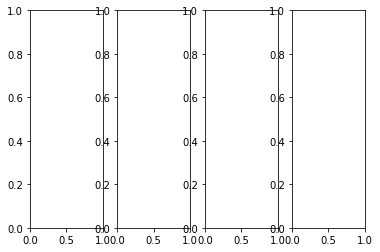

In [ ]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

4개의 공간을 리턴하는 것을 볼 수 있다.  
이를 각각 sns_barplot의 ax의 값으로 순차적으로 넣어준다.  

앞의 값 figure를 통해 그래프의 크기 등을 조절할 수 있다.  
figure.set_size.inches(숫자, 숫자)를 직접 수정해보면 이해가 쉽다.

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'Hour')]

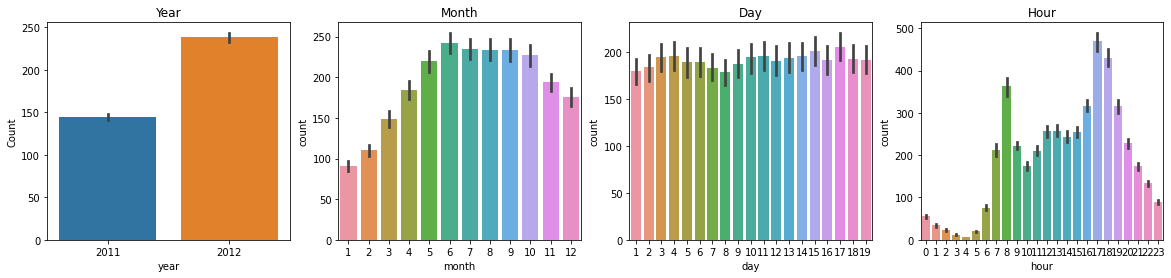

In [ ]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(20,4)

sns.barplot(data=bike_df, x="year", y="count", ax=ax1)
sns.barplot(data=bike_df, x="month", y="count", ax=ax2)
sns.barplot(data=bike_df, x="day", y="count", ax=ax3)
sns.barplot(data=bike_df, x="hour", y="count", ax=ax4)

ax1.set(ylabel='Count',title="Year")
ax2.set(xlabel='month',title="Month")
ax3.set(xlabel='day', title="Day")
ax4.set(xlabel='hour', title="Hour")

* 연도별 대여량은 2011년 보다 2012년이 더 많다.
* 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다. 즉, 겨울보다 여름에 대여량이 많다.
* 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.

위 subplot의 경우에는 행은 1, 열은 4개의 값을 가지도록 한다. 그런데 만약에 행이 2개 이상. 즉, 두 줄 이상으로 차트를 배치할 수도 있지 않을까? 다음은 행이 2개, 열이 2개인 경우에 subplot을 사용하는 예시이다. 같은 행끼리 묶어주는 것이 앞 예시와 다르다.

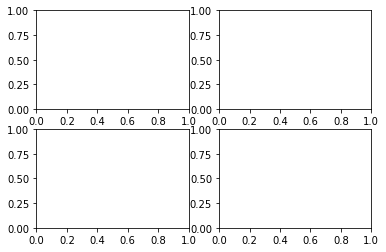

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

행이 2개일 때는 리턴값의 형태가 ((ax1, ax2), (ax3, ax4))와 같다.  
각각의 행을 따로 리턴하는 것이다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Working Day Count')]

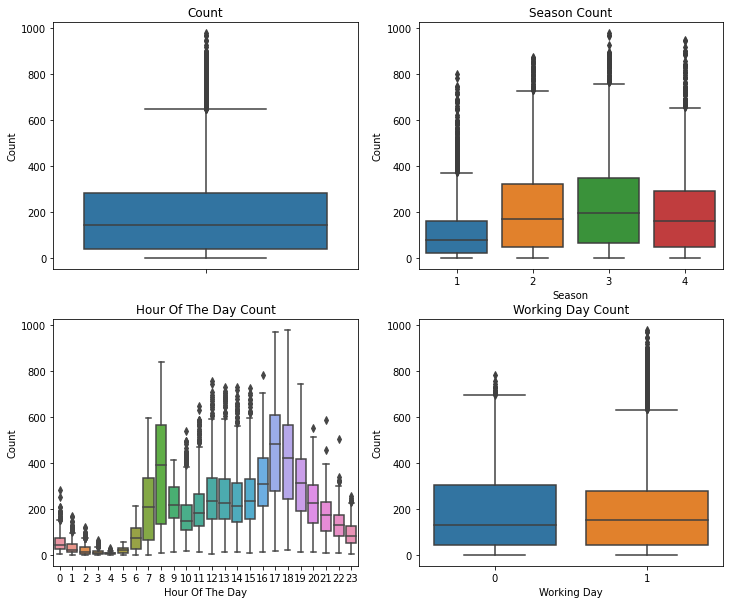

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(12, 10)
sns.boxplot(data=bike_df, y="count",orient="v",ax=ax1)
sns.boxplot(data=bike_df, y="count",x="season",orient="v",ax=ax2)
sns.boxplot(data=bike_df, y="count",x="hour",orient="v",ax=ax3)
sns.boxplot(data=bike_df, y="count",x="workingday",orient="v",ax=ax4)

ax1.set(ylabel='Count',title="Count")
ax2.set(xlabel='Season', ylabel='Count',title="Season Count")
ax3.set(xlabel='Hour Of The Day', ylabel='Count',title="Hour Of The Day Count")
ax4.set(xlabel='Working Day', ylabel='Count',title="Working Day Count")

박스 플롯은 분위수로 구분하여 25% ~ 75%의 값까지 박스로 둘러쌓은 뒤에, 중앙값에는 선을 그어준다.

계절별 대여량은 봄이 가장 적다.  
자전거 대여량은 근무일이 아닐 때가 조금 더 많다.

앞서 datetime.dt를 사용하여 year, month, day, hout에 대한 4개의 열을 추가했었다.

월화수목금토일을 나누고 싶다면 dayofweek를 사용할 수 있다.

In [ ]:
bike_df["dayofweek"] = bike_df["datetime"].dt.dayofweek
bike_df.shape

(10886, 17)

In [ ]:
bike_df["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

0 = 월요일 ~ 6 = 일요일입니다.

큰 차이는 없지만 5,6(토, 일)의 대여량이 조금더 많은 것으로 보아 앞서 살펴본 workingday의 Boxplot 내용과 어느정도 일치하는 것으로 보입니다.

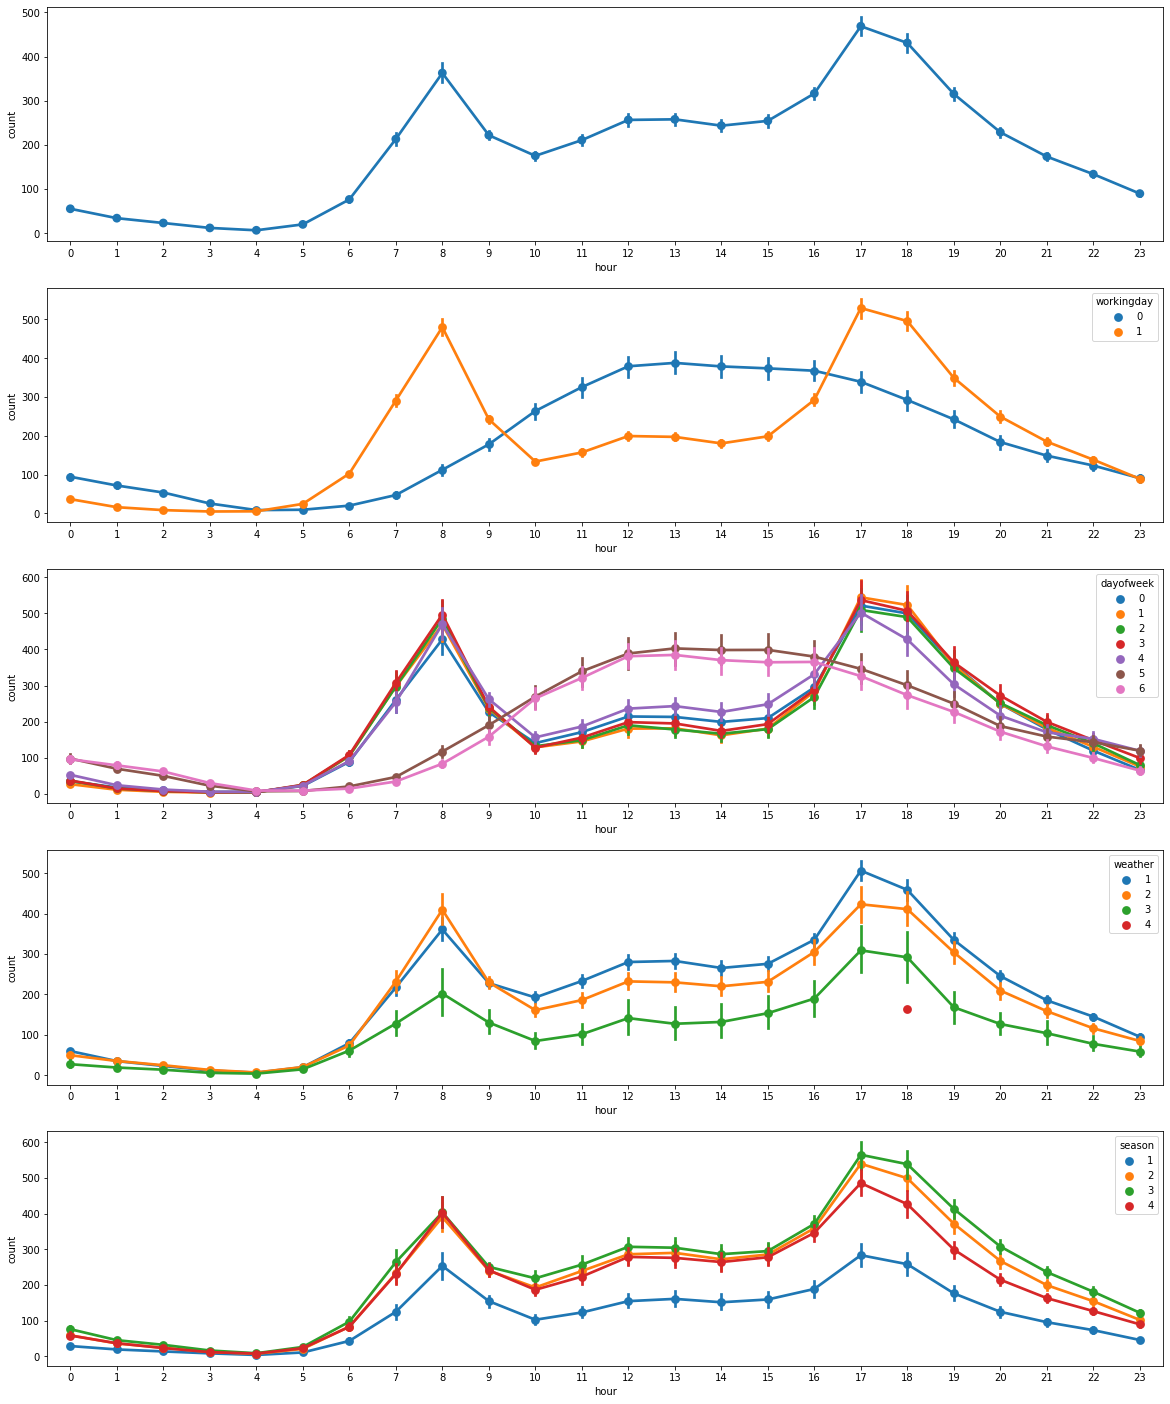

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(20,25)

sns.pointplot(data=bike_df, x="hour", y="count", ax=ax1)
sns.pointplot(data=bike_df, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=bike_df, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=bike_df, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=bike_df, x="hour", y="count", hue="season", ax=ax5)

첫번째 그래프인 시간별 대여량을 보면, 주로 출퇴근 시간에 많이 대여하는 것처럼 보인다.  
두번째 그래프인 워킹데이와 주말을 비교해서보면 주말에는 오후 대여량도 많다.  
세번째 그래프인 요일별 대여량을 보면 5, 6이 토요일, 일요일인만큼 역시나 오후 대여량이 많다.  
네번째 그래프인 날씨별 대여량을 보면 눈, 비가 올 때는 대여량이 굉장히 적다.  
다섯번째 그래프인 계절별 대여량을 보면 봄에 대여량이 가장 적다.

In [ ]:
cols = ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]
corr = bike_df[cols].corr(method='pearson')
corr.values

array([[ 1.        ,  0.98494811,  0.46709706,  0.31857128, -0.06494877,
        -0.01785201,  0.39445364],
       [ 0.98494811,  1.        ,  0.46206654,  0.31463539, -0.04353571,
        -0.057473  ,  0.38978444],
       [ 0.46709706,  0.46206654,  1.        ,  0.49724969, -0.3481869 ,
         0.09227619,  0.69041357],
       [ 0.31857128,  0.31463539,  0.49724969,  1.        , -0.26545787,
         0.09105166,  0.97094811],
       [-0.06494877, -0.04353571, -0.3481869 , -0.26545787,  1.        ,
        -0.31860699, -0.31737148],
       [-0.01785201, -0.057473  ,  0.09227619,  0.09105166, -0.31860699,
         1.        ,  0.10136947],
       [ 0.39445364,  0.38978444,  0.69041357,  0.97094811, -0.31737148,
         0.10136947,  1.        ]])

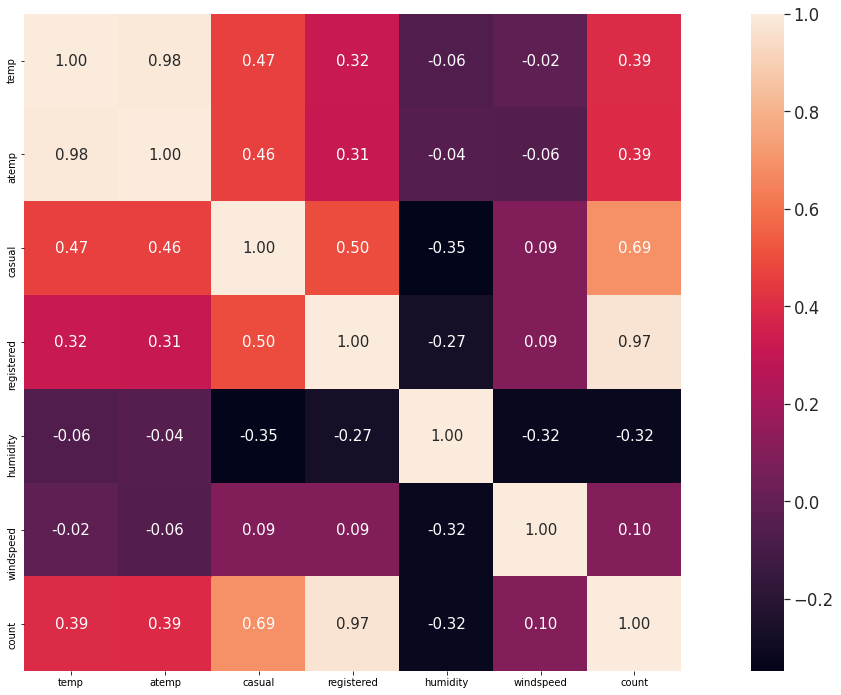

In [ ]:
# 우선 fig를 통해서 차트의 크기를 조정
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# 위에서 얻은 ax값을 ax의 인자값으로 넣는다. ax=ax
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols,
            ax=ax)

plt.tight_layout()
plt.show()

AttributeError: ignored

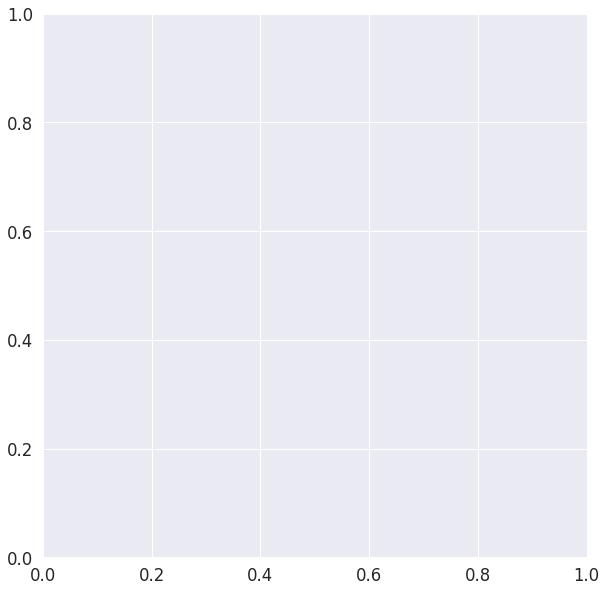

In [ ]:
# 우선 fig를 통해서 차트의 크기를 조정
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# 위에서 얻은 ax값을 ax의 인자값으로 넣는다. ax=ax
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklables=cols,
            xticklabels=cols,
            ax=ax)

plt.tight_layout()
plt.show()

* 온도, 습도, 풍속은 거의 연관관계가 없다. 
* 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다. 즉, registed는 사실 테스트 데이터 예측에 사용하기에는 무리다.
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 사실상 같은 데이터라고 봐도 무방해서 피처로 사용하기에 적합하지 않을 수 있다. 이를 다중공선성이라 한다.

산점도

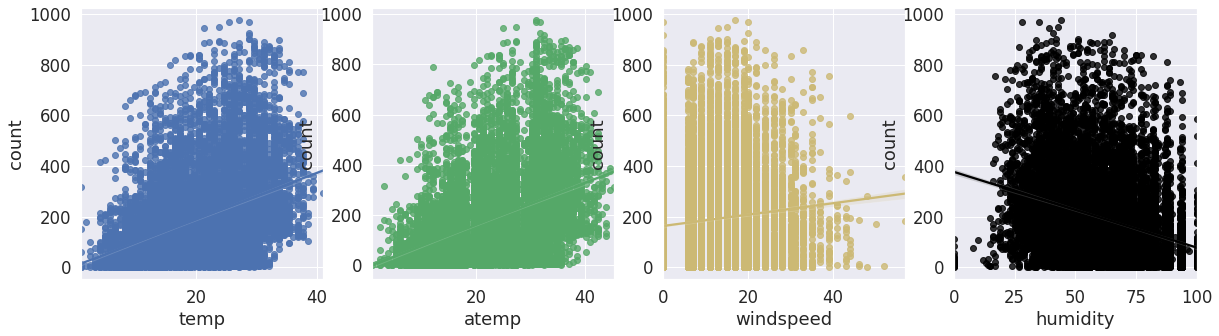

In [ ]:
fig,(ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)

sns.regplot(x="temp", y="count", data=bike_df, color='b', ax=ax1)
sns.regplot(x="atemp", y="count", data=bike_df, color='g', ax=ax2)
sns.regplot(x="windspeed", y="count", data=bike_df, color='y', ax=ax3)
sns.regplot(x="humidity", y="count", data=bike_df, color='black', ax=ax4)

* 풍속은 데이터가 0에 몰려있다. 
* 습도 또한 데이터가 0과 100에 몰려있다.

#정규화

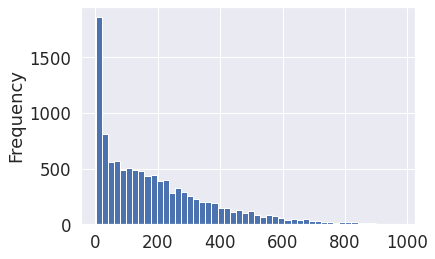

In [ ]:
bike_df['count'].plot(kind='hist', bins=50)

count 열의 값이 정규 분포가 아닌 0~200사이에 왜곡돼 있는 것을 볼 수 있습니다. 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것입니다. 여기서는 Numpy의 log1p()를 사용하겠습니다.

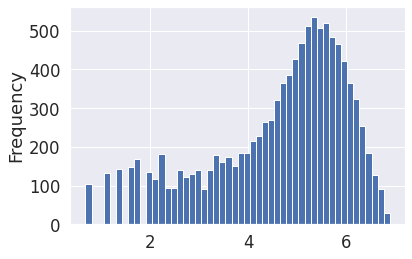

In [ ]:
y_log_transform = np.log1p(bike_df['count'])
y_log_transform.plot(kind='hist', bins=50)

로그로 Target 값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됐습니다.